## Example notebook for the Vertex-based approach

In this notebook, we present both, the APNM and the EPNM algorithms applied to the concentric circles toy problem. 

The concentrict circles problem consists of a 2-dimensional dataset, where the a neural network is trained to differenciate samples that belong to different circles.

In [1]:
using Flux
using Flux: onehotbatch, argmax, crossentropy, throttle

using Base.Iterators: repeated

using LazySets
using LaTeXStrings

include("../src/reachAlgorithm.jl")

Academic license - for non-commercial use only - expires 2023-11-10


Main.reachAlgorithm

We used the Flux library to train and test the neural network models that we used is this toy problem. The LazySets library is employed to make it easy to work with polytopes.

In [2]:
using .reachAlgorithm

The reachAlgorithm library contains the implementation for the algorithms APNM, PAPNM and EPNM.

In [3]:
using Plots

Finally, we also used the Plots library to visualize the data that we are processing.

### Creating dataset

To create the concentric circles dataset, we sampled linearly 200 examples for each of the circles.

In [4]:
N = 200

theta = reshape(LinRange(0,2*pi,N), (1,N));

In [5]:
r1 = 1;

x1 = cos.(theta)*r1;
y1 = sin.(theta)*r1;
z1 = vcat(ones((1,N)), zeros((1,N)))

r2 = 3;

x2 = cos.(theta)*r2;
y2 = sin.(theta)*r2;
z2 = vcat(zeros((1,N)), ones((1,N)))

r3 = 2.5;

x3 = cos.(theta)*r3;
y3 = sin.(theta)*r3;
z3 = vcat(zeros((1,N)), ones((1,N)))

r4 = 3.5;

x4 = cos.(theta)*r4;
y4 = sin.(theta)*r4;
z4 = vcat(zeros((1,N)), ones((1,N)))

r5 = 0.5;

x5 = cos.(theta)*r5;
y5 = sin.(theta)*r5;
z5 = vcat(zeros((1,N)), ones((1,N)))

r6 = 1.5;

x6 = cos.(theta)*r6;
y6 = sin.(theta)*r6;
z6 = vcat(zeros((1,N)), ones((1,N)))

input_data = hcat(vcat(x1,y1), vcat(x2,y2));
output_data = hcat(z1, z2);

Next, we plot each of the circles (the outer circle in orange and the inner circle in blue), wrapped by two dashed circles. 

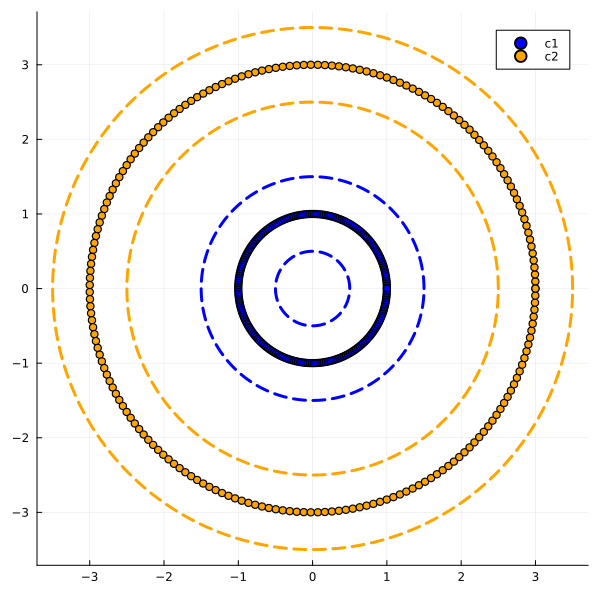

In [8]:
p1 = scatter(x1[1,:], y1[1,:], labels="c1", color=:blue)
p2 = plot!(x5[1,:], y5[1,:], line = (:dash, 3), color=:blue, labels="")
p3 = plot!(x6[1,:], y6[1,:], line = (:dash, 3), color=:blue, labels="")
p4 = scatter!(x2[1,:], y2[1,:], labels="c2", color=:orange)
p5 = plot!(x3[1,:], y3[1,:], line = (:dash, 3), color=:orange, labels="")
p6 = plot!(x4[1,:], y4[1,:], line = (:dash, 3), color=:orange, labels="")
plot(p6)
plot!(size=(600,600))
# savefig("images/dataset.png")

### Defining and training the model

Now, we define the neural network classifier that will be used to classify input sample into one the classes (inner or outer circle).

In this case, we employed a simples neural network with 2 hidden layers of 4 neurons each (observe that the actions of the hidder layers are ReLU functions).

In [9]:
rede_neural = Chain(
    Dense(2, 4, relu),
    Dense(4, 4, relu),
    Dense(4, 2),
);
ps = Flux.params(rede_neural);

We define the crossentropy as the loss function for the training process and ADAM as the optimizer.

In [22]:
loss(x, y) = Flux.crossentropy(softmax(rede_neural(x)), y)

evalcb = () -> @show(loss(input_data, output_data))

datasetx = repeated((input_data, output_data), 5000);

C = collect(datasetx);

opt = ADAM();

In [14]:
Flux.train!(loss, ps, datasetx, opt, cb = throttle(evalcb, 1))

loss(input_data, output_data) = 1.0337171065904847


To visualize the behavior of the trained model, we plot the probability of the outer class for $-3.5 \leq \mathbf{x} \leq 3.5$, where $\mathbf{x} = (x_1, x_2)$ for this problem.

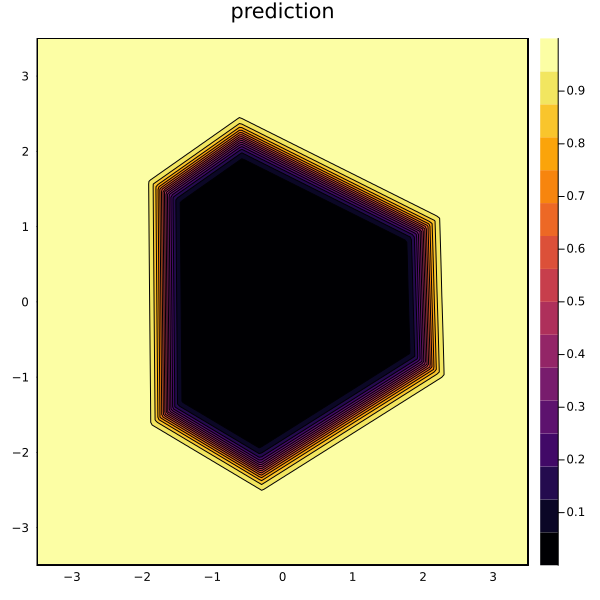

In [15]:
xs = LinRange(-3.5,3.5,200);
ys = LinRange(-3.5,3.5,200);

u_real = reshape([softmax(rede_neural(reshape([x,y], (2,1))))[2] for x in xs for y in ys], 200, 200);

p2 = plot(xs, ys, u_real, linetype=:contourf,title = "prediction");

plot(p2)
plot!(size=(600,600))
# savefig("images/c2_probability.png")

### Defining verification properties and applying the vertex-based approaches

We define now the property to be verified. To do so, we have to define the input set $\mathcal{X}$ and the expected output set $\mathcal{Y}$.

In this example, we want to verify that those samples in $\mathcal{X} = \{\mathbf{x} \mid ||\mathbf{x}||_2 \leq 1.3 \land \mathbf{x} \in \mathbb{R}^2\}$ are mapped in $\mathcal{Y} = \{\mathbf{y} \mid y_2 \leq y_1 \land \mathbf{y} \in \mathbb{R}^2\}$.

As the algorithms APNM, PAPNM and EPNM work with a VPolytopes as inputs, we have to approximate $\mathcal{X}$ to a polytope represented by its vertices. In this case, we have that the set of vertices of $\mathcal{X}$ is given by:

In [23]:
P = transpose([1.33261 0.0; 1.07811 -0.783289; 0.4118 -1.26739; -0.4118 -1.26739; -1.07811 -0.783289; -1.33261 0.0; -1.07811 0.783289; -0.4118 1.26739; 0.4118 1.26739; 1.07811 0.783289])

2×10 transpose(::Matrix{Float64}) with eltype Float64:
 1.33261   1.07811    0.4118   -0.4118   …  -0.4118   0.4118   1.07811
 0.0      -0.783289  -1.26739  -1.26739      1.26739  1.26739  0.783289

Notice that, we approximated $\mathcal{X}$ by a decagon (observe the following figure).

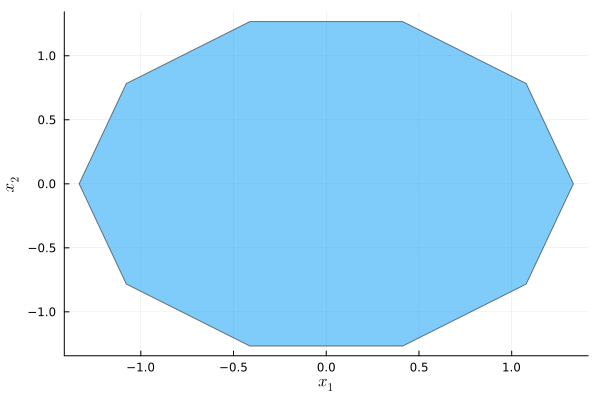

In [28]:
plot(VPolytope(P))
xlabel!(L"x_1")
ylabel!(L"x_2")

The following step consists of giving both, the set of vertices and the neural network as input to the verification algorithms.

#### APNM

In [29]:
P_hat_convex_hull = network_mapping(P, rede_neural);

Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10


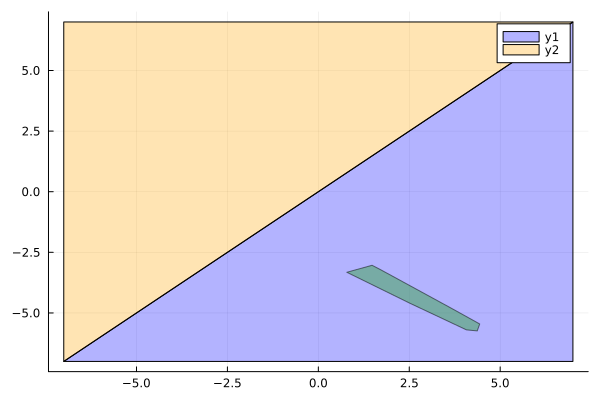

In [33]:
a = 7
b = 7

p2 = plot()

p2 = plot!(Shape([-a,a,a], [-a,-a,a]), fill = (0.3, :blue))
p2 = plot!(Shape([b,-b,-b], [b,b,-b]), fill = (0.3, :orange))
p2 = plot!(VPolytope(P_hat_convex_hull))

plot(p2)

#### EPNM

In [31]:
P_hat_exact = network_mapping2_removing_non_vertices(P, rede_neural);

Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only - expires 2023-11-10
Academic license - for non-commercial use only -

2

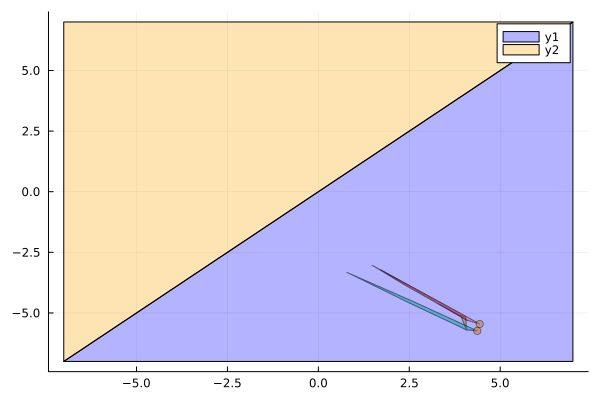

In [34]:
a = 7
b = 7

p2 = plot()

p2 = plot!(Shape([-a,a,a], [-a,-a,a]), fill = (0.3, :blue));
p2 = plot!(Shape([b,-b,-b], [b,b,-b]), fill = (0.3, :orange));

for i in 1:size(P_hat_exact)[1]
    
    if !isempty(P_hat_exact[i])
    
        if length(size(P_hat_exact[i])) > 1
                
            p2 = plot!(VPolytope(P_hat_exact[i]))
            
        else
        
            p2 = scatter!(P_hat_exact[i][1,:], P_hat_exact[i][2,:])
        
        end
        
    end
    
end

plot(p2)

In [43]:
check_inclusion([-1 1], [0], P_hat_exact)

:holds

#### APNM x EPNM

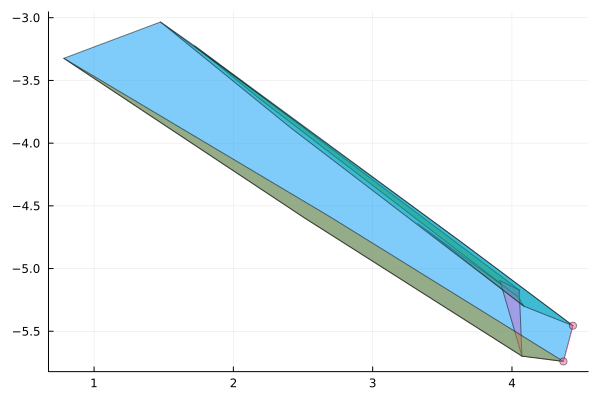

In [36]:
p2 = plot()
p2 = plot!(VPolytope(P_hat_convex_hull))
for i in 1:size(P_hat_exact)[1]
    
    if !isempty(P_hat_exact[i])
    
        if length(size(P_hat_exact[i])) > 1
                
            p2 = plot!(VPolytope(P_hat_exact[i]))
            
        else
        
            p2 = scatter!(P_hat_exact[i][1,:], P_hat_exact[i][2,:])
        
        end
        
    end
    
end
plot(p2)